In [1]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
from torchvision import transforms
from omegaconf import OmegaConf as oc

%matplotlib inline
%config InlineBackend.figure_format='retina'

import models.utils as utils
import evals.embed_evals as evals
import utils.plot_data as plot
import utils.gen_triplets as gen
import warnings
warnings.filterwarnings("ignore")

## synthetic features.pkl

In [143]:
df = pd.read_csv("datasets/wv_3d/df.csv")
features = ["head size","body size","tail size","texture"]

In [158]:
files = utils.dataset_filenames("datasets/wv_3d/train")
files = [x.split("/")[-1] for x in files[:,0]]
train_features = np.array([list(df[df["img_id"]==f][features].iloc[0]) for f in files])

In [160]:
files = utils.dataset_filenames("datasets/wv_3d/test")
files = [x.split("/")[-1] for x in files[:,0]]
test_features = np.array([list(df[df["img_id"]==f][features].iloc[0]) for f in files])

## generated alignments

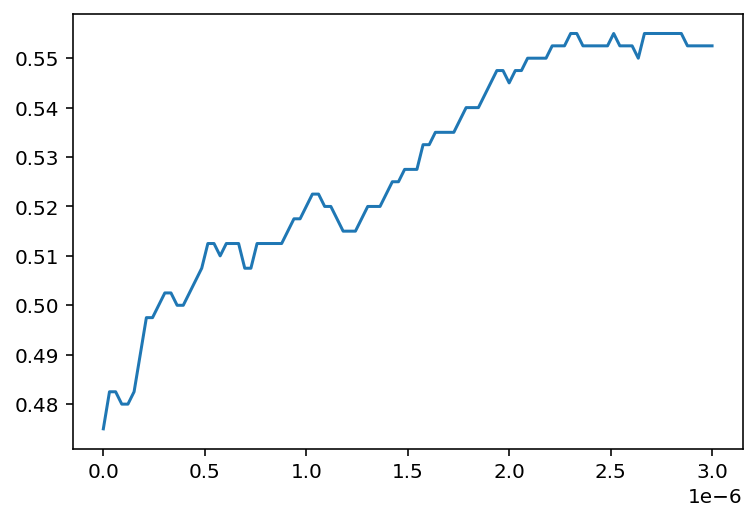

In [26]:
df = pd.read_csv("data_gen/search.csv")
plt.plot(df["weights"],df["aligns"])

In [31]:
df.iloc[13]["weights"]

3.93939393939394e-07

In [30]:
np.where(df["aligns"]==0.5)

(array([ 9, 12, 13]),)

In [12]:
train_embeds = pickle.load(open("datasets/wv_3d/train_features.pkl","rb"))
test_embeds = pickle.load(open("datasets/wv_3d/test_features.pkl","rb"))
y_train = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/train")])
y_test = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/test")])

In [32]:
evals.distorted_1nn(train_embeds, y_train, test_embeds, y_test, [3.93939393939394e-07,0,1,1])

0.5

In [41]:
2.69e-03

0.00269

In [43]:
aligns=[]
w1s = [0, 3.94e-07, 2.64e-06,9.61e-06,2.56e-05,4.8e-05,1.28e-03]
aligns = [0.475,0.5,0.55,0.6,0.65,0.7,0.75]
for w1 in w1s:
    weights = [w1,0,1,1]
    aligns.append(evals.distorted_1nn(train_embeds, y_train, test_embeds, y_test, weights))
aligns

[0.475, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]

### triplet gen

In [2]:
train_features = pickle.load(open("datasets/wv_3d/train_features.pkl","rb"))
valid_features = pickle.load(open("datasets/wv_3d/valid_features.pkl","rb"))
test_features = pickle.load(open("datasets/wv_3d/test_features.pkl","rb"))
y_train = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/train")])
y_valid = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/valid")])
y_test = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/test")])

In [8]:
w2s = [0,0.00075,0.002693,0.011,1]
aligns = [0.8,0.85,0.9,0.95,1]
total = 30000

triplet_dir = "datasets/wv_3d_triplets"
for w2,align in zip(w2s, aligns):
    weights = [1,w2,1,1] 
    train_triplets, valid_triplets, test_triplets, train_triplets_filtered, valid_triplets_filtered, test_triplets_filtered =\
        gen.get_alignment_filtered_triplets(train_features, valid_features, test_features, y_train, y_valid, y_test, weights, total)
    print(len(train_triplets_filtered)/len(train_triplets), len(valid_triplets_filtered)/len(valid_triplets), len(test_triplets_filtered)/len(test_triplets))
    # break
    align_dir = os.path.join(triplet_dir,f"align={str(align)}")
    if not os.path.isdir(align_dir): os.mkdir(align_dir)
    pickle.dump(train_triplets, open(f"{align_dir}/train_triplets.pkl", "wb"))
    pickle.dump(valid_triplets, open(f"{align_dir}/valid_triplets.pkl", "wb"))
    pickle.dump(test_triplets, open(f"{align_dir}/test_triplets.pkl", "wb"))
    pickle.dump(train_triplets_filtered, open(f"{align_dir}/train_triplets_filtered.pkl","wb"))
    pickle.dump(valid_triplets_filtered, open(f"{align_dir}/valid_triplets_filtered.pkl","wb"))
    pickle.dump(test_triplets_filtered, open(f"{align_dir}/test_triplets_filtered.pkl","wb"))

0.7647083333333333 0.77 0.771
0.7625833333333333 0.772 0.7685
0.7645833333333333 0.766 0.7741666666666667
0.7639166666666667 0.775 0.7708333333333334
0.7710833333333333 0.7821666666666667 0.7741666666666667


In [9]:
train_triplets = pickle.load(open("datasets/wv_3d_triplets/align=0.8/train_triplets.pkl","rb"))
valid_triplets = pickle.load(open("datasets/wv_3d_triplets/align=0.8/valid_triplets.pkl","rb"))
test_triplets = pickle.load(open("datasets/wv_3d_triplets/align=0.8/test_triplets.pkl","rb"))
for p in [0.05,0.1, 0.2, 0.3, 0.4, 0.5]:
    dir = os.path.join("datasets/wv_3d_triplets/align=0.8_noisy",str(p))
    if not os.path.isdir(dir): os.mkdir(dir)
    train_noisy = gen.get_noisy_triplets(train_triplets, p)
    valid_noisy = gen.get_noisy_triplets(valid_triplets, p)
    test_noisy = gen.get_noisy_triplets(test_triplets, p)
    pickle.dump(train_noisy, open(f"{dir}/train_triplets.pkl","wb"))
    pickle.dump(valid_noisy, open(f"{dir}/valid_triplets.pkl","wb"))
    pickle.dump(test_noisy, open(f"{dir}/test_triplets.pkl","wb"))

In [44]:
w1s = [0, 3.94e-07, 2.64e-06,9.61e-06,2.56e-05,4.8e-05,1.28e-03]
aligns = [0.475,0.5,0.55,0.6,0.65,0.7,0.75]

total = 30000
triplet_dir = "datasets/wv_3d_triplets"
for w2,align in zip(w2s, aligns):
    weights = [w1,0,1,1] 
    train_triplets, valid_triplets, test_triplets, train_triplets_filtered, valid_triplets_filtered, test_triplets_filtered =\
        gen.get_alignment_filtered_triplets(train_features, valid_features, test_features, y_train, y_valid, y_test, weights, total)
    print(len(train_triplets_filtered)/len(train_triplets), len(valid_triplets_filtered)/len(valid_triplets), len(test_triplets_filtered)/len(test_triplets))
    # break
    align_dir = os.path.join(triplet_dir,f"align={str(align)}")
    if not os.path.isdir(align_dir): os.mkdir(align_dir)
    pickle.dump(train_triplets, open(f"{align_dir}/train_triplets.pkl", "wb"))
    pickle.dump(valid_triplets, open(f"{align_dir}/valid_triplets.pkl", "wb"))
    pickle.dump(test_triplets, open(f"{align_dir}/test_triplets.pkl", "wb"))
    pickle.dump(train_triplets_filtered, open(f"{align_dir}/train_triplets_filtered.pkl","wb"))
    pickle.dump(valid_triplets_filtered, open(f"{align_dir}/valid_triplets_filtered.pkl","wb"))
    pickle.dump(test_triplets_filtered, open(f"{align_dir}/test_triplets_filtered.pkl","wb"))

0.7497916666666666 0.7491666666666666 0.7588333333333334
0.7552083333333334 0.7543333333333333 0.7468333333333333
0.7483333333333333 0.7445 0.7496666666666667
0.7500416666666667 0.7451666666666666 0.737
0.748781199216634 0.7516666666666667 0.7411666666666666


## yaml generation

In [47]:
yaml_dir = "models/configs/wv_3d/align_triplets"
base = oc.load(f"{yaml_dir}/align=0.8.yaml")
w1s = [0, 3.94e-07, 2.64e-06,9.61e-06,2.56e-05,4.8e-05,1.28e-03] + [1]*4
w2s = [0]*7 + [0,0.0008,0.003,0.0123,1]
aligns = [0.475,0.5,0.55,0.6,0.65,0.7,0.75] + [0.8,0.85,0.9,0.95,1] 

In [48]:
for w1, w2, align in zip(w1s, w2s, aligns):
    weights = [w1,w2,1,1] 
    train_triplets = base.train_triplets.replace("0.8",str(align))
    valid_triplets = base.valid_triplets.replace("0.8",str(align))
    test_triplets = base.test_triplets.replace("0.8",str(align))
    wandb_group = base.wandb_group.replace("0.8",str(align))
    overwrite = {"weights":weights, "train_triplets":train_triplets,"valid_triplets":valid_triplets,
    "test_triplets":test_triplets,"wandb_group":wandb_group}
    oc.save(oc.merge(base,overwrite), f"models/configs/wv_3d/align_triplets/align={align}.yaml")

In [49]:
yaml_dir = "models/configs/wv_3d/filtered_triplets"
base_filtered = oc.load(f"{yaml_dir}/align=0.8_filtered.yaml")

In [50]:
for w1, w2, align in zip(w1s, w2s, aligns):
    weights = [w1,w2,1,1] 
    train_triplets = base_filtered.train_triplets.replace("0.8",str(align))
    valid_triplets = base_filtered.valid_triplets.replace("0.8",str(align))
    test_triplets = base_filtered.test_triplets.replace("0.8",str(align))
    wandb_group = base_filtered.wandb_group.replace("0.8",str(align))
    overwrite = {"weights":weights, "train_triplets":train_triplets,"valid_triplets":valid_triplets,
    "test_triplets":test_triplets,"wandb_group":wandb_group}
    oc.save(oc.merge(base_filtered,overwrite), f"models/configs/wv_3d/filtered_triplets/align={align}_filtered.yaml")

In [98]:
yaml_dir = "models/configs/wv_3d/noisy_triplets"
base_noisy = oc.load(f"{yaml_dir}/noise=0.1.yaml")

In [99]:
for p in [0.1, 0.05,0.2, 0.3, 0.4, 0.5]:
    train_triplets = base_noisy.train_triplets.replace("0.1",str(p))
    valid_triplets = base_noisy.valid_triplets.replace("0.1",str(p))
    test_triplets = base_noisy.test_triplets.replace("0.1",str(p))
    wandb_group = base_noisy.wandb_group.replace("0.1",str(p))
    overwrite = {"train_triplets":train_triplets,"valid_triplets":valid_triplets,
    "test_triplets":test_triplets,"wandb_group":wandb_group}
    oc.save(oc.merge(base_noisy,overwrite), f"models/configs/wv_3d/noisy_triplets/noise={p}.yaml")